# Prosup  Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data Analysis Section

In [2]:
file = 'Subjects/Fazil/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)

In [5]:
b,a = signal.butter(1, 50,fs=2000)
for labels in emg_labels:
    df[labels] = signal.lfilter(b, a,df[labels])

In [6]:
b,a = signal.butter(3, 3,fs=2000)
for labels in angle_lables:
    df[labels] = signal.lfilter(b, a,df[labels])

<AxesSubplot:title={'center':'Subjects/Fazil/computed_Bulb.csv'}>

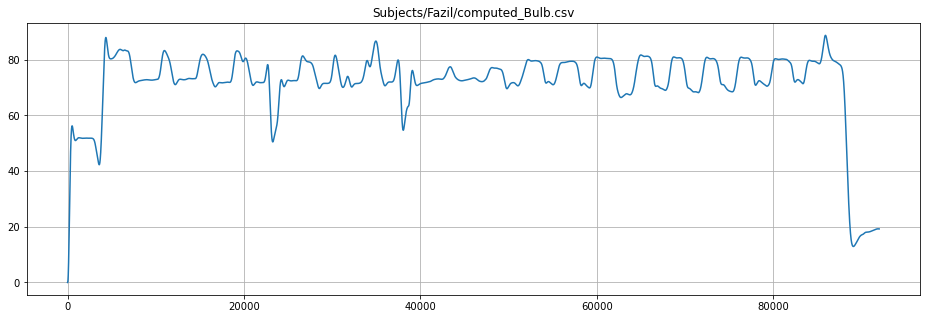

In [7]:
df['Pronation_Angle'].plot(figsize=(16,5),title=file,grid=True)#,xticks=np.linspace(0,len(df),5)

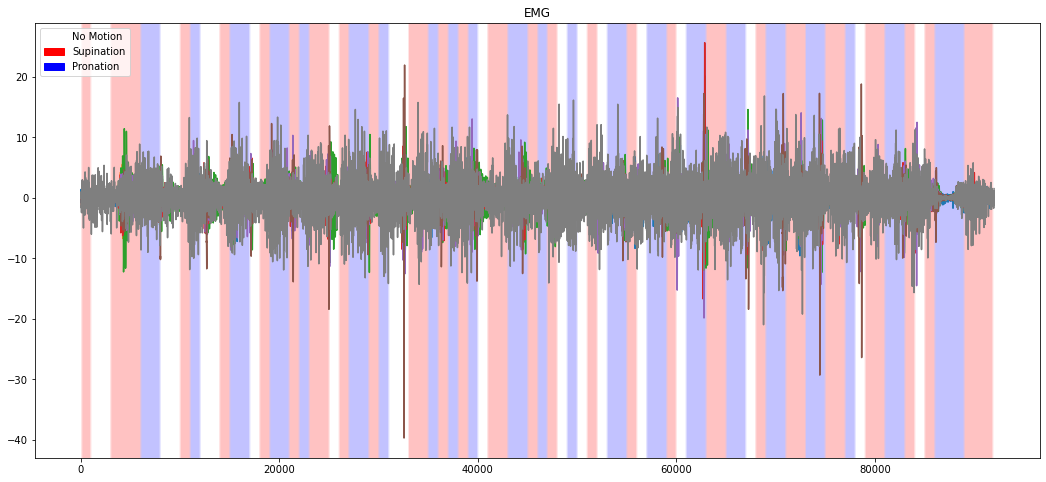

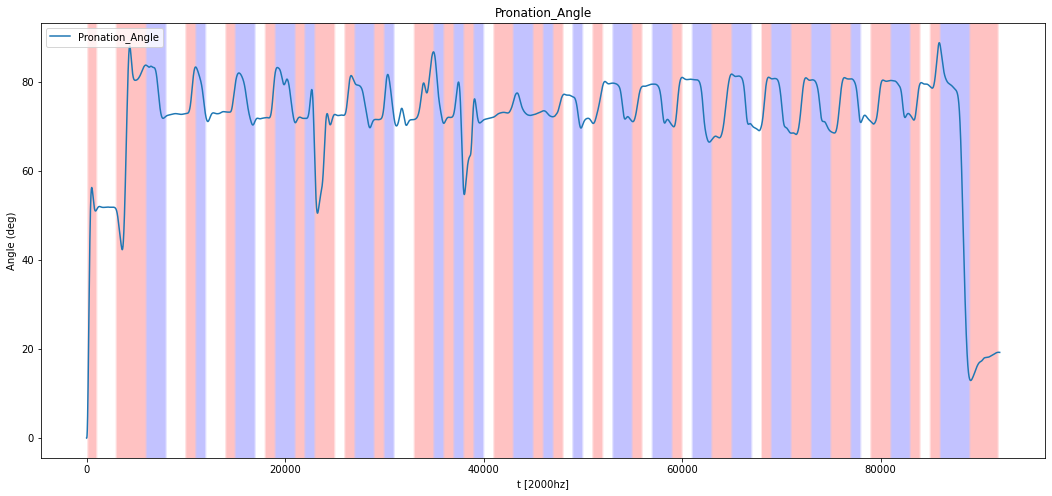

0 -> 20.708446866485012 %
1 -> 40.05449591280654 %
2 -> 39.237057220708444 %


(1835, 250, 8)

In [8]:
X, y = prep_data_prosup(df,250,interval=50,Normalize=True,plot=True,angle_thresh=0.0008,rms=False)
X.shape

## File Name Generation

In [36]:
files = []
subjects = ['Fazil','Nikhil','Abhishek','Jai', 'Deepti', 'Nirmayee','Ingy'] #'Fazil/day_04_14_21' ,'Varun'
# subjects = ['Varun'] #'Fazil/day_04_14_21' ,'Varun'

In [37]:
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Bulb','Screw'] # 'Bulb','Hammer' ,'Cup'
#     trial_names = ['Bulb','Hammer' ,'Cup','Screw']
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/computed_Bulb.csv',
 'Subjects/Fazil/computed_Bulb01.csv',
 'Subjects/Fazil/computed_Bulb02.csv',
 'Subjects/Fazil/computed_Screw.csv',
 'Subjects/Fazil/computed_Screw01.csv',
 'Subjects/Fazil/computed_Screw02.csv',
 'Subjects/Nikhil/computed_Bulb.csv',
 'Subjects/Nikhil/computed_Bulb01.csv',
 'Subjects/Nikhil/computed_Bulb02.csv',
 'Subjects/Nikhil/computed_Screw.csv',
 'Subjects/Nikhil/computed_Screw01.csv',
 'Subjects/Nikhil/computed_Screw02.csv',
 'Subjects/Abhishek/computed_Bulb.csv',
 'Subjects/Abhishek/computed_Bulb01.csv',
 'Subjects/Abhishek/computed_Bulb02.csv',
 'Subjects/Abhishek/computed_Screw.csv',
 'Subjects/Abhishek/computed_Screw01.csv',
 'Subjects/Abhishek/computed_Screw02.csv',
 'Subjects/Jai/computed_Bulb.csv',
 'Subjects/Jai/computed_Bulb01.csv',
 'Subjects/Jai/computed_Bulb02.csv',
 'Subjects/Jai/computed_Screw.csv',
 'Subjects/Jai/computed_Screw01.csv',
 'Subjects/Jai/computed_Screw02.csv',
 'Subjects/Deepti/computed_Bulb.csv',
 'Subjects/Deepti/

In [38]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0)[6500:85000])#[4500:85000]

In [39]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
    angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
    b,a = signal.butter(order, cf,fs=fs)
    for i in range(len(files_df)):
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,files_df[i][labels])
        files_df[i][emg_labels] = np.array(emg_df)
        
        b,a = signal.butter(3, 3,fs=2000)
        for labels in angle_lables:
            files_df[i][labels] = signal.lfilter(b, a,files_df[i][labels])
            
    return files_df

In [40]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

In [7]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [41]:
test_rep_files = ['Subjects/Nikhil/computed_Bulb02.csv', 
                  'Subjects/Jai/computed_Bulb02.csv', 
                  'Subjects/Abhishek/computed_Bulb02.csv']
tr_range = [20000,30000]

In [42]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [29]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

<ipython-input-10-556929648f63>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
c:\users\moham\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-10-556929648f63>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

## Data Augumentation

### Gausian Noise

In [11]:
files_df_gausian = []
for df in tqdm(files_df):
    snr = choice(np.linspace(60,90,5))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],snr))
    df[emg_labels] = emg_array
    files_df_gausian.append(df)

files_df = files_df+files_df_gausian
len(files_df)

44

### Rearrange 

In [43]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [44]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

126

## Data Prep Pipeline

### Parameters

In [45]:
window = 250
interval = 25
Normalize = True
rms = False
angle_thresh = 0.0008

In [46]:
X_prosup, y_prosup = multiple_prep_data_prosup(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh)
print(X_prosup.shape,y_prosup.shape)


(363060, 250, 8) (363060, 3)


In [35]:
np.save('X_test_prosup',X_prosup)
np.save('y_test_prosup',y_prosup)

## Whole Normalize

In [23]:
def norm2(X):
    X2 = X.reshape((X.shape[0]*window,X.shape[2]))
    column_max = []
    for i in tqdm(range(X2.shape[1])):
        scaler = StandardScaler()
        X2[:,i] = scaler.fit_transform(X2[:,i].reshape(-1,1)).reshape((len(X2)))
#         X2[:,i] = (X2[:,i] - X2[:,i].max())/variance(X2[:,i]) 
    return X2.reshape(X.shape)
X_prosup = norm2(X_prosup)

In [54]:
def norm2(X):
    X2 = X.reshape((X.shape[0]*window,X.shape[2]))
    scaler_mx = MinMaxScaler((0,1))
    scaler_std = StandardScaler()
#     X2 = scaler_std.fit_transform(X2)
    X2 = scaler_mx.fit_transform(X2)
    return X2.reshape(X.shape)
X_prosup = norm2(X_prosup)

### TW Normalize

‘‘time window normalization’’ (i.e., subtracting to
each time window the mean and dividing it by the standard
deviation) and ‘‘normalization based on training data’’ (i.e.,
subtracting to all the time windows the training data mean and
dividing them by the training data standard deviation).

In [86]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [87]:
X_mean = np.zeros(X_prosup[0].shape)
for x in X_prosup:
    X_mean = X_mean + x
X_mean = X_mean/X_prosup.shape[0]
X_std = np.sqrt(variance(X_prosup))
np.save('mean_std',np.array([X_mean,X_std]))

In [12]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]

In [13]:
X = []
for x in tqdm(X_prosup):
    X.append((x-X_mean)/X_std)
X_prosup = np.array(X)

In [130]:
np.save('prepared_data/X_prosup_rearr_tw',X_prosup)
np.save('prepared_data/y_prosup_rearr_tw',y_prosup)

In [2]:
X_prosup = np.load('prepared_data/X_prosup_rearr_tw.npy')
y_prosup = np.load('prepared_data/y_prosup_rearr_tw.npy')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_prosup, y_prosup,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(290448, 250, 8)
(72612, 250, 8)
(290448, 3)
(72612, 3)


In [48]:
np.save('prepared_data/X_train',X_train)
np.save('prepared_data/X_test',X_test)
np.save('prepared_data/y_train',y_train)
np.save('prepared_data/y_test',y_test)

In [30]:
np.save('prepared_data/X',X_prosup)
np.save('prepared_data/y',y_prosup)

In [203]:
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(521280, 250, 8)
(130320, 250, 8)
(521280, 3)
(130320, 3)


In [65]:
X_train = np.load('prepared_data/X_train.npy')
X_test = np.load('prepared_data/X_test.npy')
y_train = np.load('prepared_data/y_train.npy')
y_test = np.load('prepared_data/y_test.npy')
# X = np.load('prepared_data/X.npy')
# y = np.load('prepared_data/y.npy')

In [49]:
del y_prosup, X_prosup, files_df

In [50]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [51]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [52]:
print(count(y_train))
print(count(y_test))

0 - 79752 [ 27.45827136010577 %]
1 - 108290 [ 37.283782294937474 %]
2 - 102406 [ 35.25794634495676 %]
None
0 - 19875 [ 27.371508841513798 %]
1 - 27112 [ 37.338181016911804 %]
2 - 25625 [ 35.290310141574395 %]
None


# InceptionTime Trainer

In [53]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [54]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=256,nb_epochs=100,nb_filters=32,
                            use_residual=True, use_bottleneck=True, depth=16, kernel_size=11)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 250, 32)      256         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_16 (MaxPooling1D) (None, 250, 8)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_86 (Conv1D)              (None, 250, 32)      10240       conv1d_85[0][0]                  
____________________________________________________________________________________________

In [ ]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/100
1135/1135 [==============================] - 439s 380ms/step - loss: 1.0453 - accuracy: 0.4331 - val_loss: 1.0182 - val_accuracy: 0.4562


c:\users\moham\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
1135/1135 [==============================] - 421s 371ms/step - loss: 1.0056 - accuracy: 0.4721 - val_loss: 0.9939 - val_accuracy: 0.4899
Epoch 3/100
1135/1135 [==============================] - 425s 374ms/step - loss: 0.9666 - accuracy: 0.5035 - val_loss: 0.9540 - val_accuracy: 0.5097
Epoch 4/100
1135/1135 [==============================] - 425s 374ms/step - loss: 0.9212 - accuracy: 0.5369 - val_loss: 0.9212 - val_accuracy: 0.5365
Epoch 5/100
1135/1135 [==============================] - 447s 394ms/step - loss: 0.8717 - accuracy: 0.5699 - val_loss: 0.8692 - val_accuracy: 0.5731
Epoch 6/100
1135/1135 [==============================] - 446s 393ms/step - loss: 0.8151 - accuracy: 0.6078 - val_loss: 0.8762 - val_accuracy: 0.5810
Epoch 7/100
1135/1135 [==============================] - 444s 391ms/step - loss: 0.7516 - accuracy: 0.6480 - val_loss: 0.8391 - val_accuracy: 0.5956
Epoch 8/100
1135/1135 [==============================] - 450s 397ms/step - loss: 0.6795 - accuracy: 0.6916

In [63]:
clf.model = load_model('best_models/prosup_250_norm/prosup_250_norm.hdf5')

In [27]:
best_model = load_model('best_model.hdf5')
# best_model.save('models/prosup_{}_norm.hdf5'.format(window))

In [ ]:
system_sleep()

## Testing

In [34]:
model = load_model('best_models/prosup_250_norm/prosup_250_norm.hdf5')

In [18]:
X_mean = np.load('mean_std_master_norm.npy')[0]
X_std = np.load('mean_std_master_norm.npy')[1]

In [19]:
X = []
for x in tqdm(X_prosup):
    X.append((x-X_mean)/X_std)
X_prosup = np.array(X)

In [32]:
count(y_prosup)

0 - 205 [ 17.521367521367523 %]
1 - 579 [ 49.48717948717949 %]
2 - 386 [ 32.99145299145299 %]


In [35]:
model.evaluate(X_prosup,y_prosup)

37/37 [==============================] - 3s 26ms/step - loss: 3.1910 - accuracy: 0.5009


[3.1909942626953125, 0.5008547306060791]

## Plot Results

In [52]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [53]:
metrics_df

,precision,accuracy,recall,duration
0,0.977353,0.978112,0.979682,24035.79844


<AxesSubplot:title={'center':'Loss'}>

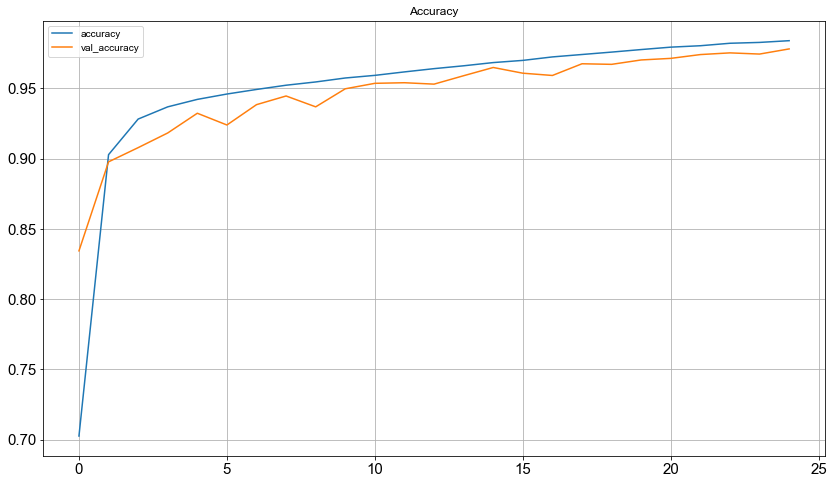

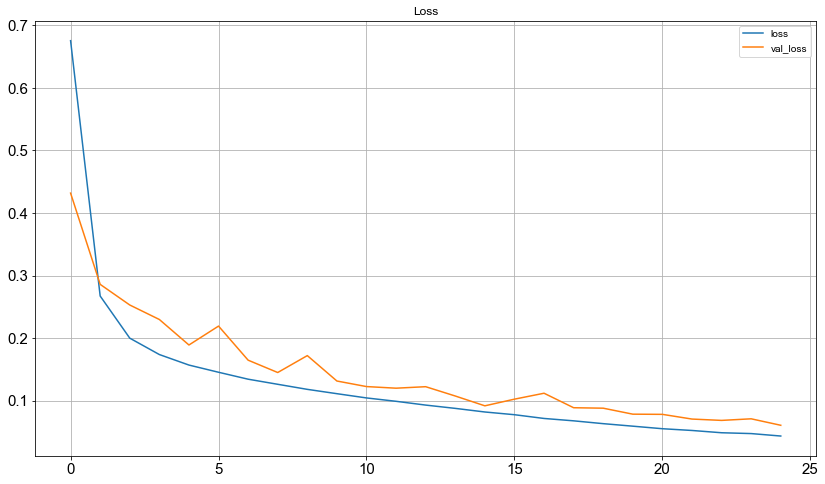

In [54]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [ ]:
system_sleep()

In [ ]:
import os
os.system('shutdown /s /f /t 30')